In [2]:
pip install pandas numpy scikit-learn imbalanced-learn matplotlib seaborn statsmodels


Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
    --------------------------------------- 0.3/11.5 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.5 MB 258.0 kB/s eta 0:00:43
   - -------------------------------------- 0.5/11.5 MB 258.0 kB/s eta 0:00:43
   - -------------------------------------- 0.5/11.5 MB 258.0 kB/s eta 0:00:43
   - -------------------------------------- 0.5/11.5 MB

In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score



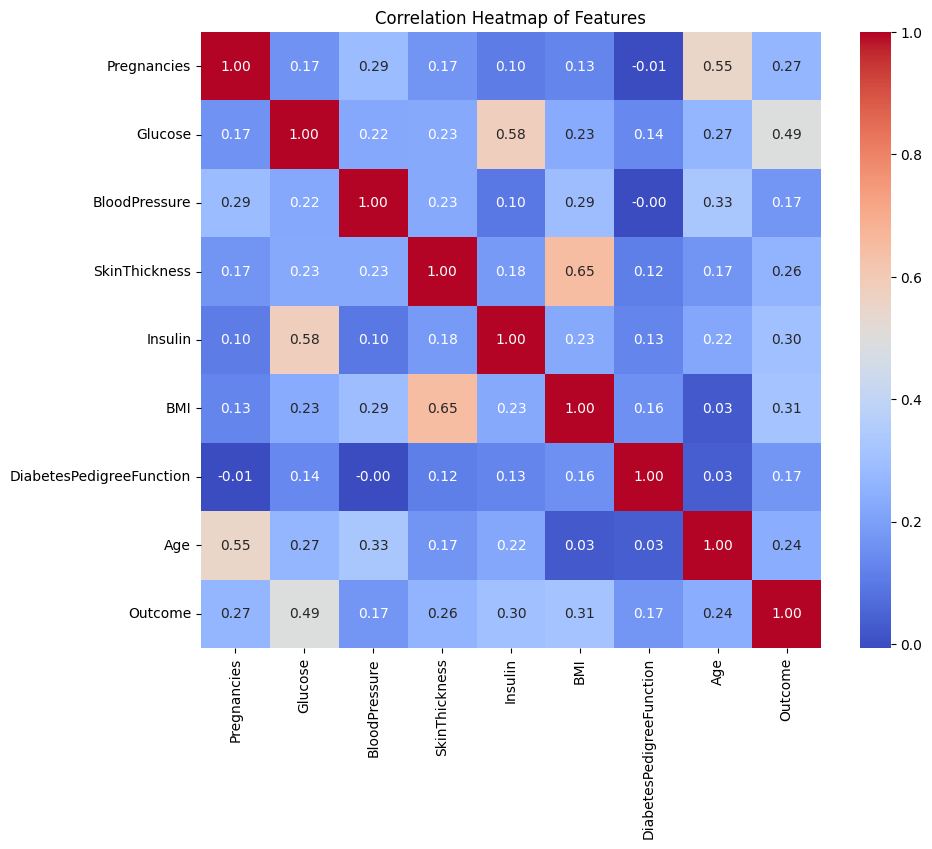

In [43]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Load your dataset
file_path = "diabetes.csv"  # Update the path to your dataset
data = pd.read_csv(file_path)

# Replace zeros with NaN for imputation (optional, based on your dataset's preprocessing needs)
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)  # Use np.nan instead of pd.NA

# Calculate the correlation matrix
correlation_matrix = data.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))  # Adjust size as needed
sns.heatmap(
    correlation_matrix,
    annot=True,          # Show correlation values
    fmt=".2f",           # Limit to 2 decimal places
    cmap="coolwarm",     # Color scheme
    cbar=True            # Show color bar
)
plt.title("Correlation Heatmap of Features")
plt.show()



Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...


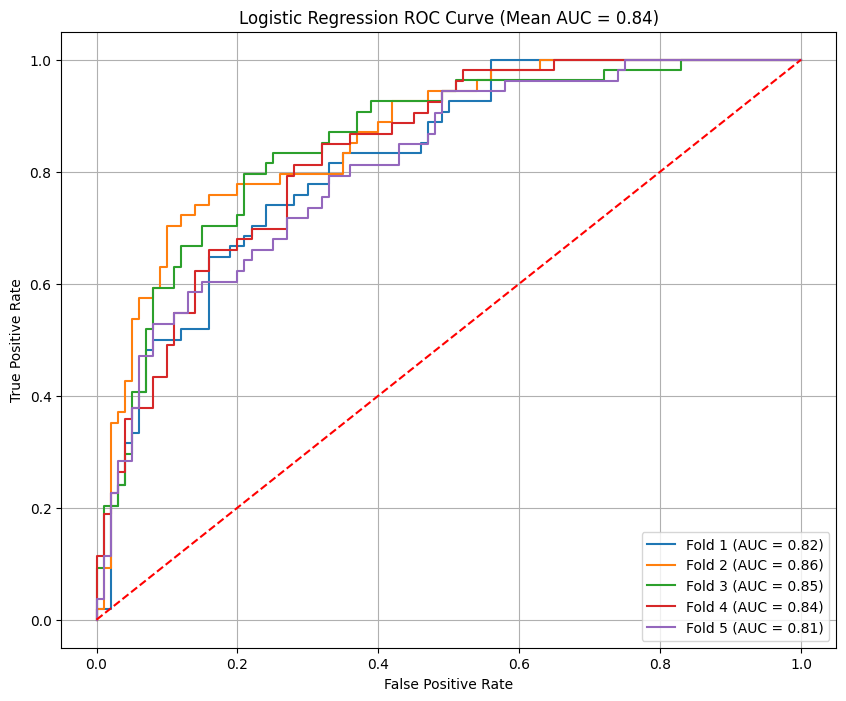

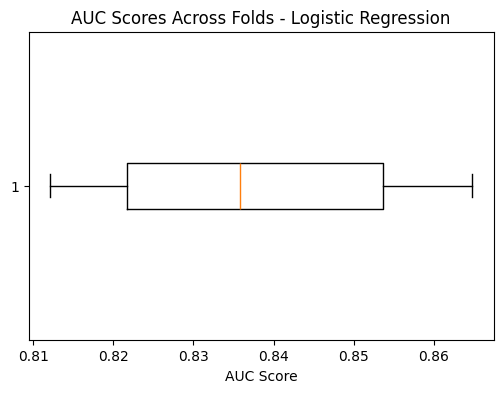


Mean AUC across all folds: 0.8376
Mean F1-Score across all folds: 0.6798
Mean Accuracy across all folds: 0.7577
Best Hyperparameters: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}


In [ ]:
#logistic regression

# Load the dataset
file_path = "diabetes.csv"
data = pd.read_csv(file_path)

# Replace zeros with NaN for imputation in relevant columns
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure', 'DiabetesPedigreeFunction']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)

# Splitting into features and target
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_auc = []
fold_f1 = []
fold_accuracy = []  


# Prepare for ROC plots
plt.figure(figsize=(10, 8))

# Perform 5-fold cross-validation
best_params = None
best_mean_auc = -1

for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nProcessing Fold {fold + 1}...")

    # Split the data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Iterative imputation 
    iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train = iterative_imputer.fit_transform(X_train)
    X_test = iterative_imputer.transform(X_test)


    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Hyperparameter tuning with GridSearchCV
    param_grid = {
        'C': [0.01, 0.1, 1, 10, 100],
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear']
    }
    grid_search = GridSearchCV(
        LogisticRegression(random_state=42),
        param_grid,
        cv=3,
        scoring='roc_auc'
    )
    grid_search.fit(X_train, y_train)

    # Train Logistic Regression Model with best parameters
    best_logistic_model = grid_search.best_estimator_
    best_logistic_model.fit(X_train, y_train)

    # Predict probabilities and calculate metrics
    y_pred_proba = best_logistic_model.predict_proba(X_test)[:, 1]
    y_pred = best_logistic_model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    fold_auc.append(roc_auc)
    fold_f1.append(f1)
    fold_accuracy.append(accuracy)


    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

    # Track the best model across folds
    if np.mean(fold_auc) > best_mean_auc:
        best_mean_auc = np.mean(fold_auc)
        best_params = grid_search.best_params_

# Finalize the ROC plot
mean_auc = np.mean(fold_auc)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f"Logistic Regression ROC Curve (Mean AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Boxplot of AUC scores
plt.figure(figsize=(6, 4))
plt.boxplot(fold_auc, vert=False)
plt.title("AUC Scores Across Folds - Logistic Regression")
plt.xlabel("AUC Score")
plt.show()

print(f"\nMean AUC across all folds: {mean_auc:.4f}")
print(f"Mean F1-Score across all folds: {np.mean(fold_f1):.4f}")
mean_accuracy = np.mean(fold_accuracy)
print(f"Mean Accuracy across all folds: {mean_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")



Processing Fold 1...
Best parameters for fold 1: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Processing Fold 2...
Best parameters for fold 2: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Processing Fold 3...
Best parameters for fold 3: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Processing Fold 4...
Best parameters for fold 4: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

Processing Fold 5...
Best parameters for fold 5: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


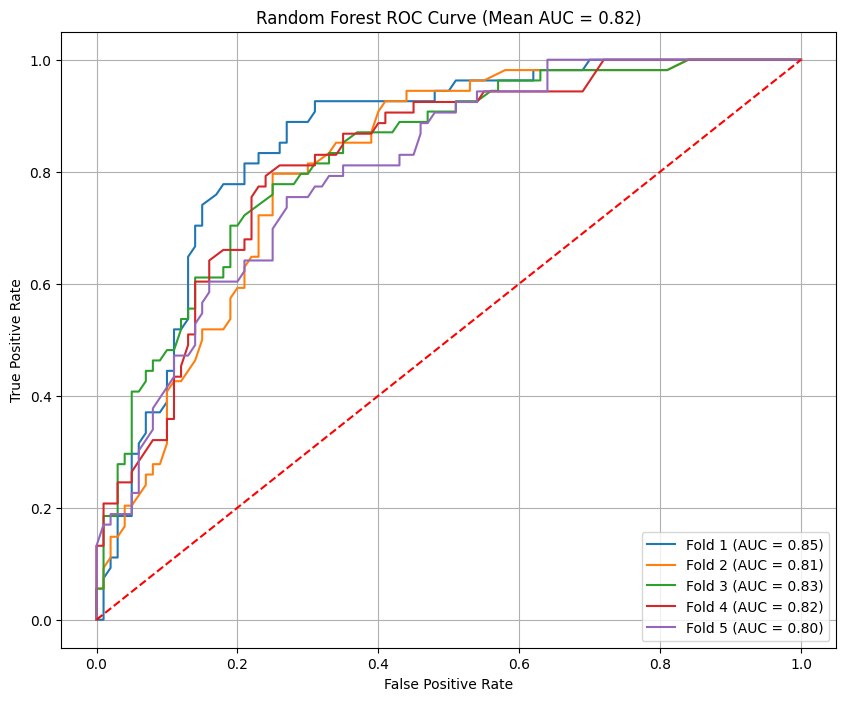

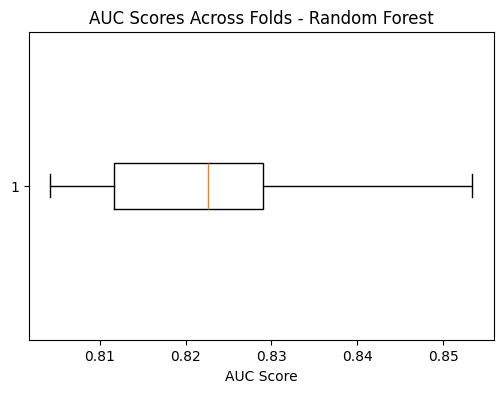


Mean AUC across all folds: 0.8242
Mean F1-score across all folds: 0.6693
Mean Accuracy across all folds: 0.7591
Best Hyperparameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}


In [ ]:
#random forest

# Load the dataset
file_path = "diabetes.csv"
data = pd.read_csv(file_path)

# Replace zeros with NaN for imputation in relevant columns
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure', 'DiabetesPedigreeFunction']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)

# Splitting into features and target
X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_auc = []  # Store AUC for each fold
fold_f1 = []   # Store F1-score for each fold
fold_accuracy = []  # To store accuracy for each fold


# Prepare for ROC plots
plt.figure(figsize=(10, 8))

# Hyperparameter grid for Random Forest
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

best_params = None  # To store the best parameters

# Perform 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nProcessing Fold {fold + 1}...")

    # Split the data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    # Iterative Imputation for all features
    iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train = iterative_imputer.fit_transform(X_train)
    X_test = iterative_imputer.transform(X_test)


    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Hyperparameter tuning
    grid_search = GridSearchCV(
        estimator=RandomForestClassifier(random_state=42),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)
    best_params = grid_search.best_params_
    print(f"Best parameters for fold {fold + 1}: {best_params}")

    # Train the model with best parameters
    rf_model = RandomForestClassifier(random_state=42, **best_params)
    rf_model.fit(X_train, y_train)

    # Predict probabilities and calculate AUC
    y_pred_proba = rf_model.predict_proba(X_test)[:, 1]
    y_pred = rf_model.predict(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    accuracy = accuracy_score(y_test, y_pred)
    fold_accuracy.append(accuracy)
    fold_auc.append(roc_auc)

    # Calculate F1-score
    f1 = f1_score(y_test, y_pred)
    fold_f1.append(f1)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

# Finalize the ROC plot
mean_auc = np.mean(fold_auc)
mean_f1 = np.mean(fold_f1)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f"Random Forest ROC Curve (Mean AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Boxplot of AUC scores
plt.figure(figsize=(6, 4))
plt.boxplot(fold_auc, vert=False)
plt.title("AUC Scores Across Folds - Random Forest")
plt.xlabel("AUC Score")
plt.show()

print(f"\nMean AUC across all folds: {mean_auc:.4f}")
print(f"Mean F1-score across all folds: {mean_f1:.4f}")
mean_accuracy = np.mean(fold_accuracy)
print(f"Mean Accuracy across all folds: {mean_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")



Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...


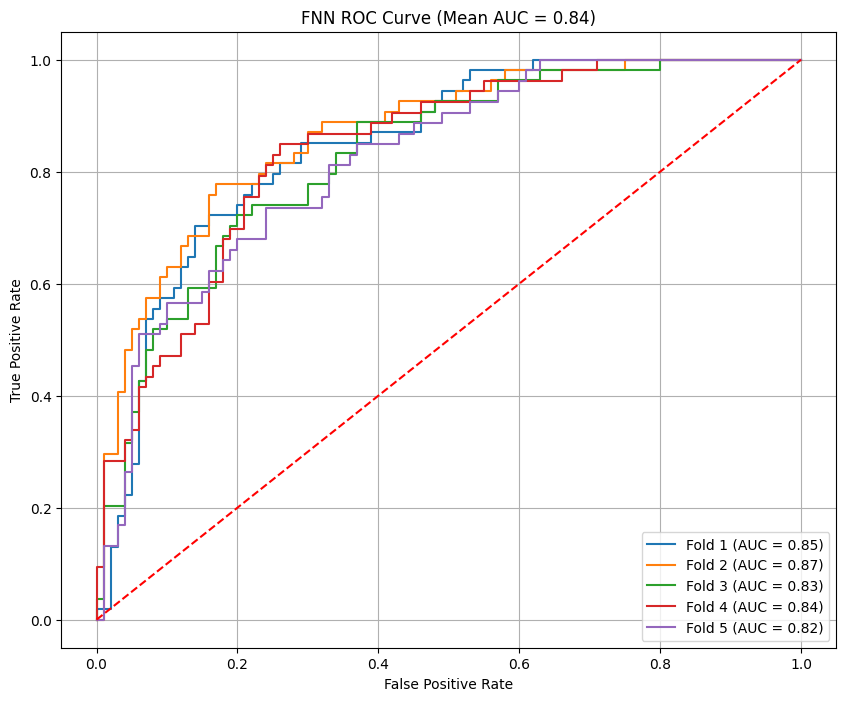

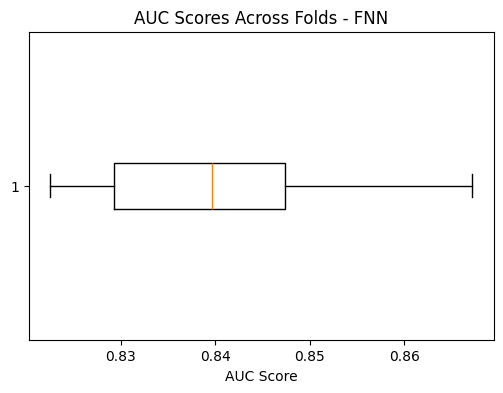


Mean AUC across all folds: 0.8412
Mean F1-score across all folds: 0.7024
Mean Accuracy across all folds: 0.7591
Best Hyperparameters: {'hidden_layers': [64, 32, 16], 'learning_rate': 0.0005}


In [ ]:
#FNN

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Define the Feedforward Neural Network (FNN)
class FNN(nn.Module):
    def __init__(self, input_size, hidden_sizes=[128, 64, 32], dropout_rate=0.4):
        super(FNN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_sizes[0])
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])
        self.fc4 = nn.Linear(hidden_sizes[2], 1)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.relu(self.fc3(x))
        x = self.sigmoid(self.fc4(x))
        return x

# Load dataset
file_path = "diabetes.csv"
data = pd.read_csv(file_path)

# Replace zeros with NaN for imputation in relevant columns
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure', 'DiabetesPedigreeFunction']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)

X = data.drop('Outcome', axis=1).values
y = data['Outcome'].values

# Initialize imputation strategies
mode_imputer = SimpleImputer(strategy='most_frequent')
iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
knn_imputer = KNNImputer(n_neighbors=5)
mean_imputer = SimpleImputer(strategy='mean')

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_auc = []
fold_f1 = []
fold_accuracy = []

# Prepare for ROC plots
plt.figure(figsize=(10, 8))

# Hyperparameter grid
hidden_layer_sizes = [[128, 64, 32], [256, 128, 64], [64, 32, 16]]
learning_rates = [0.001, 0.0005, 0.0001]
best_params = None
best_auc = 0

# Perform 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nProcessing Fold {fold + 1}...")

    # Split the data
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]


    # Iterative Imputation for all features
    iterative_imputer = IterativeImputer(max_iter=10, random_state=42)
    X_train = iterative_imputer.fit_transform(X_train)
    X_test = iterative_imputer.transform(X_test)


    # Apply SMOTE to the training data
    smote = SMOTE(random_state=42)
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Normalize the data
    scaler = MinMaxScaler(feature_range=(0.01, 1))
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Convert data to PyTorch tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    # Hyperparameter tuning
    for hidden_layers in hidden_layer_sizes:
        for lr in learning_rates:
            model = FNN(input_size=X_train_tensor.shape[1], hidden_sizes=hidden_layers)
            criterion = nn.BCELoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
            
            # Train the model
            model.train()
            for epoch in range(100):
                for batch_X, batch_y in DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True):
                    optimizer.zero_grad()
                    outputs = model(batch_X)
                    loss = criterion(outputs, batch_y)
                    loss.backward()
                    optimizer.step()

            # Evaluate the model
            model.eval()
            with torch.no_grad():
                y_pred_proba = model(X_test_tensor).squeeze().numpy()
                roc_auc = auc(*roc_curve(y_test, y_pred_proba)[:2])
                if roc_auc > best_auc:
                    best_auc = roc_auc
                    best_params = {'hidden_layers': hidden_layers, 'learning_rate': lr}

    # Final Model with Best Parameters
    model = FNN(input_size=X_train_tensor.shape[1], hidden_sizes=best_params['hidden_layers'])
    optimizer = torch.optim.Adam(model.parameters(), lr=best_params['learning_rate'])
    model.train()
    for epoch in range(100):
        for batch_X, batch_y in DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True):
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()

    # Evaluate with Best Parameters
    model.eval()
    with torch.no_grad():
        y_pred_proba = model(X_test_tensor).squeeze().numpy()
        y_pred = (y_pred_proba > 0.5).astype(int)
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = auc(fpr, tpr)
        fold_auc.append(roc_auc)

        accuracy = accuracy_score(y_test, y_pred)
        fold_accuracy.append(accuracy) 


        f1 = f1_score(y_test, y_pred)
        fold_f1.append(f1)

        # Plot ROC curve for each fold
        plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

# Finalize the ROC plot
mean_auc = np.mean(fold_auc)
mean_f1 = np.mean(fold_f1)
mean_accuracy = np.mean(fold_accuracy)

plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f"FNN ROC Curve (Mean AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Boxplot of AUC scores
plt.figure(figsize=(6, 4))
plt.boxplot(fold_auc, vert=False)
plt.title("AUC Scores Across Folds - FNN")
plt.xlabel("AUC Score")
plt.show()

print(f"\nMean AUC across all folds: {mean_auc:.4f}")
print(f"Mean F1-score across all folds: {mean_f1:.4f}")
print(f"Mean Accuracy across all folds: {mean_accuracy:.4f}")
print(f"Best Hyperparameters: {best_params}")



Processing Fold 1...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:29:34] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:29:35] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Fold 1: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}

Processing Fold 2...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:29:47] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Fold 2: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'subsample': 1.0}

Processing Fold 3...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:29:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Fold 3: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 1.0}

Processing Fold 4...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:30:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:30:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Fold 4: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}

Processing Fold 5...
Fitting 3 folds for each of 108 candidates, totalling 324 fits


C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:30:24] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
C:\Users\madih\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [20:30:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0c55ff5f71b100e98-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best parameters for Fold 5: {'colsample_bytree': 1.0, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500, 'subsample': 0.8}


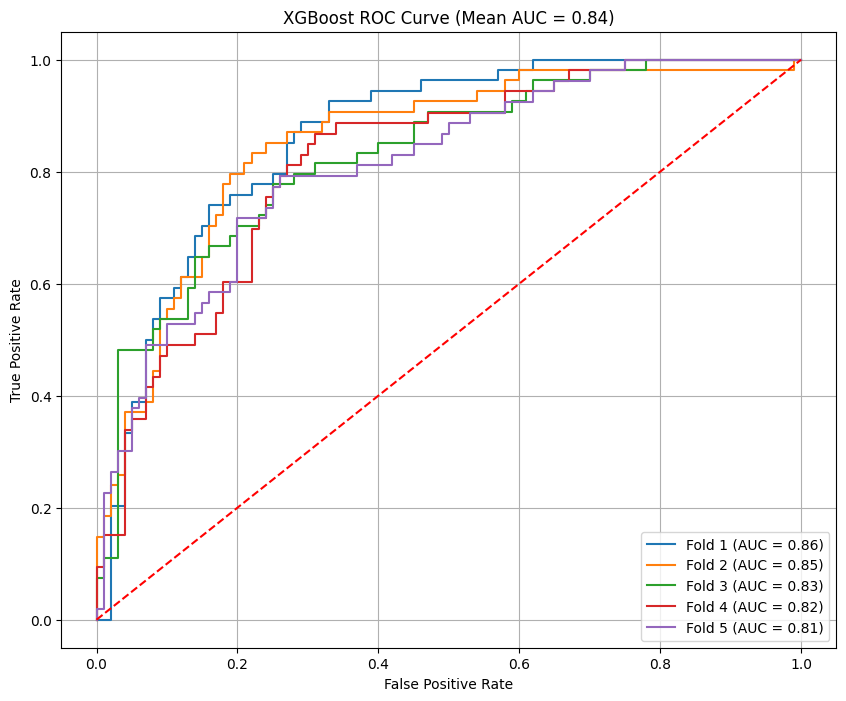

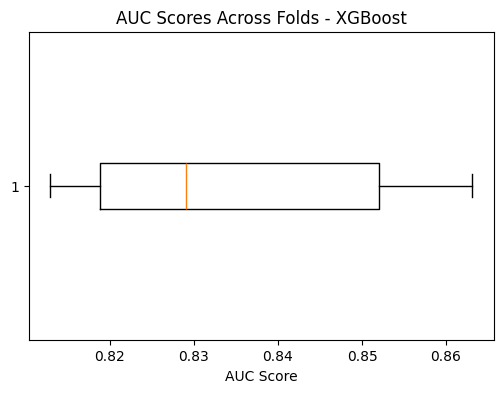


Mean AUC across all folds: 0.8352
Mean F1-score across all folds: 0.6283
Mean Accuracy across all folds: 0.7577
Best Overall Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 300, 'subsample': 0.8}


In [ ]:
#XGboost

from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "diabetes.csv"
data = pd.read_csv(file_path)

# Replace zeros with NaN for missing values in relevant columns
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)

# Splitting into features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 300, 500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_auc = []
fold_f1 = []
fold_accuracy = [] 


# Best parameters storage
best_params = None
best_auc = 0

# Prepare for ROC plots
plt.figure(figsize=(10, 8))

# Perform 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nProcessing Fold {fold + 1}...")

    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Hyperparameter tuning with GridSearchCV
    grid_search = GridSearchCV(
        estimator=XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss'),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,
        n_jobs=-1,
        verbose=1
    )
    grid_search.fit(X_train, y_train)

    # Select the best model and parameters
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)
    print(f"Best parameters for Fold {fold + 1}: {grid_search.best_params_}")

    # Evaluate the model
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)  # Add this line


    fold_auc.append(roc_auc)
    fold_f1.append(f1)
    fold_accuracy.append(accuracy)  # Store accuracy


    if roc_auc > best_auc:
        best_auc = roc_auc
        best_params = grid_search.best_params_

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

# Finalize the ROC plot
mean_auc = np.mean(fold_auc)
mean_f1 = np.mean(fold_f1)
mean_accuracy = np.mean(fold_accuracy)

plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f"XGBoost ROC Curve (Mean AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Boxplot of AUC scores
plt.figure(figsize=(6, 4))
plt.boxplot(fold_auc, vert=False)
plt.title("AUC Scores Across Folds - XGBoost")
plt.xlabel("AUC Score")
plt.show()

print(f"\nMean AUC across all folds: {mean_auc:.4f}")
print(f"Mean F1-score across all folds: {mean_f1:.4f}")
print(f"Mean Accuracy across all folds: {mean_accuracy:.4f}")
print(f"Best Overall Hyperparameters: {best_params}")



Processing Fold 1...

Processing Fold 2...

Processing Fold 3...

Processing Fold 4...

Processing Fold 5...


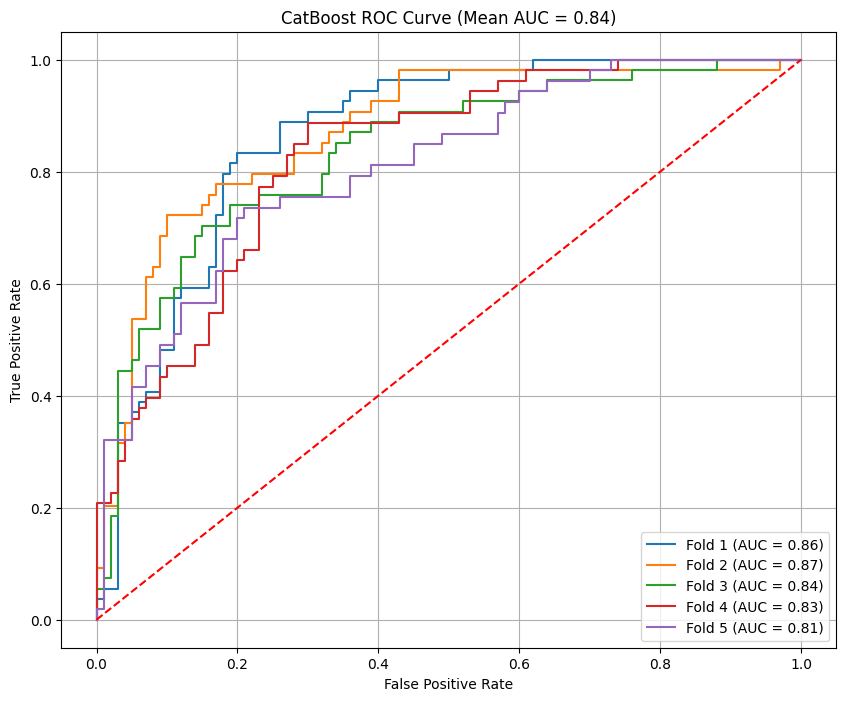


Mean AUC across folds: 0.8429
Mean F1-score across folds: 0.6401
Mean Accuracy across all folds: 0.7747

Best Parameters: {'depth': 4, 'iterations': 300, 'learning_rate': 0.05}


In [ ]:
#catboost


from catboost import CatBoostClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.impute import SimpleImputer
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
file_path = "diabetes.csv"
data = pd.read_csv(file_path)

# Replace zeros with np.nan for missing values in relevant columns
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
data[columns_to_replace_zeros] = imputer.fit_transform(data[columns_to_replace_zeros])

# Splitting into features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Define hyperparameter grid
param_grid = {
    'iterations': [300, 500],
    'learning_rate': [0.1, 0.05],
    'depth': [4, 6]
}

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_auc = []
fold_f1 = []
fold_accuracy = []

# Prepare for ROC plots
plt.figure(figsize=(10, 8))

# Perform 5-Fold Cross-Validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nProcessing Fold {fold + 1}...")

    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Hyperparameter tuning with GridSearchCV (reduced inner folds for efficiency)
    grid_search = GridSearchCV(
        estimator=CatBoostClassifier(loss_function='Logloss', random_state=42, verbose=0),
        param_grid=param_grid,
        scoring='roc_auc',
        cv=3,  # Use fewer folds for inner loop to save computation time
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Select the best model
    best_model = grid_search.best_estimator_
    best_model.fit(
        X_train, y_train, eval_set=(X_test, y_test), use_best_model=True, early_stopping_rounds=10
    )

    # Evaluate the model
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)


    fold_auc.append(roc_auc)
    fold_f1.append(f1)
    fold_accuracy.append(accuracy)


    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

# Finalize the ROC plot
mean_auc = sum(fold_auc) / len(fold_auc)
mean_f1 = sum(fold_f1) / len(fold_f1)
mean_accuracy = np.mean(fold_accuracy)
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f"CatBoost ROC Curve (Mean AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

print(f"\nMean AUC across folds: {mean_auc:.4f}")
print(f"Mean F1-score across folds: {mean_f1:.4f}")
print(f"Mean Accuracy across all folds: {mean_accuracy:.4f}")
print(f"\nBest Parameters: {grid_search.best_params_}")



Performing hyperparameter tuning...
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[LightGBM] [Info] Number of positive: 268, number of negative: 500
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 770
[LightGBM] [Info] Number of data points in the train set: 768, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348958 -> initscore=-0.623621
[LightGBM] [Info] Start training from score -0.623621
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

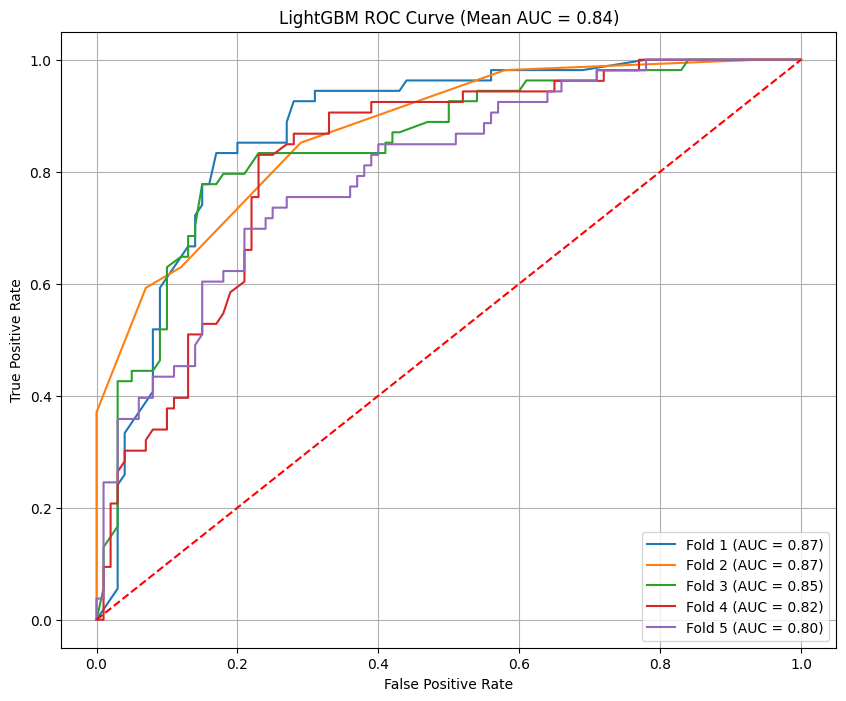


Best Parameters: {'subsample': 0.8, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.1, 'colsample_bytree': 1.0}

Mean AUC across folds: 0.8442
Mean F1-score across folds: 0.4604
Mean Accuracy across all folds: 0.7292


In [ ]:
#lightgbm

import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, auc, f1_score
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt

# Load the dataset
file_path = "diabetes.csv"
data = pd.read_csv(file_path)

# Replace zeros with NaN for missing values in relevant columns
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
data[columns_to_replace_zeros] = imputer.fit_transform(data[columns_to_replace_zeros])

# Splitting into features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Define hyperparameter grid
param_grid = {
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [3, 6, 9],
    "n_estimators": [100, 300, 500],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

# Perform hyperparameter tuning
print("Performing hyperparameter tuning...")
grid_search = RandomizedSearchCV(
    estimator=lgb.LGBMClassifier(random_state=42),
    param_distributions=param_grid,
    n_iter=10,
    scoring="roc_auc",
    cv=3,  # This is only for hyperparameter tuning
    n_jobs=-1,
    verbose=2
)
grid_search.fit(X, y)

# Select the best hyperparameters
best_params = grid_search.best_params_
print(f"\nBest hyperparameters found during tuning: {best_params}")

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_auc = []
fold_f1 = []
fold_accuracy = []

# Prepare for ROC plots
plt.figure(figsize=(10, 8))

# Perform 5-Fold Cross-Validation with the best hyperparameters
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nProcessing Fold {fold + 1}...")

    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Train LightGBM model using the best hyperparameters
    model = lgb.LGBMClassifier(
        random_state=42,
        **best_params
    )
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        eval_metric="auc",
        callbacks=[lgb.early_stopping(stopping_rounds=10)]
    )

    # Evaluate the model
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)

    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)  # Add this line


    fold_auc.append(roc_auc)
    fold_f1.append(f1)
    fold_accuracy.append(accuracy)  # Store accuracy


    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

# Finalize the ROC plot
mean_auc = sum(fold_auc) / len(fold_auc)
#mean_f1 = sum(fold_f1) / len(fold_f1)
mean_f1 = np.mean(fold_f1)
mean_accuracy = np.mean(fold_accuracy)

plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f"LightGBM ROC Curve (Mean AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Print best parameters and metrics
print(f"\nBest Parameters: {best_params}")
print(f"\nMean AUC across folds: {mean_auc:.4f}")
print(f"Mean F1-score across folds: {mean_f1:.4f}")
print(f"Mean Accuracy across all folds: {mean_accuracy:.4f}")



Processing Fold 1...
[LightGBM] [Info] Number of positive: 214, number of negative: 400
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 666
[LightGBM] [Info] Number of data points in the train set: 614, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.348534 -> initscore=-0.625489
[LightGBM] [Info] Start training from score -0.625489
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits wit

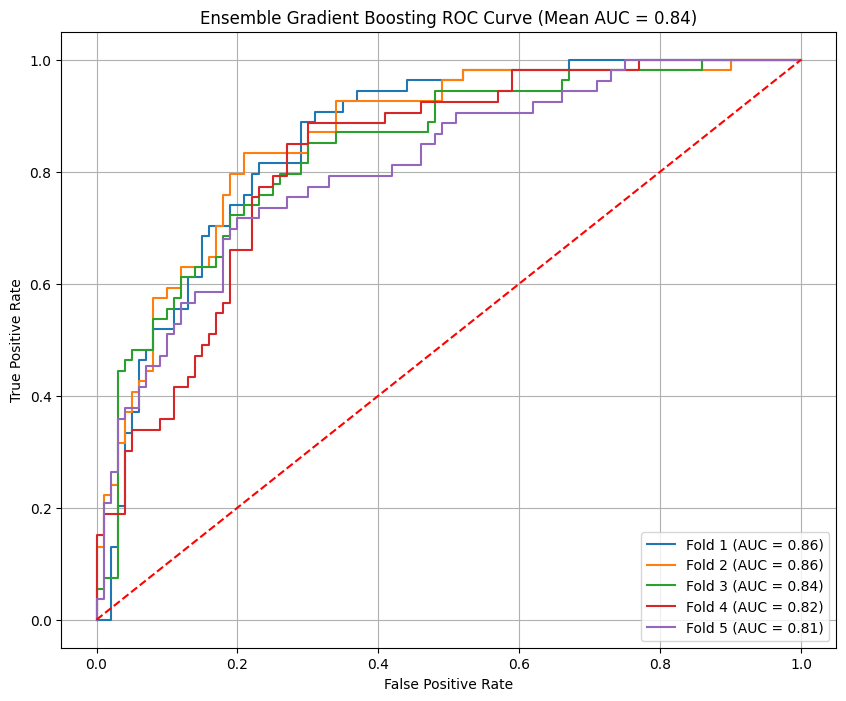

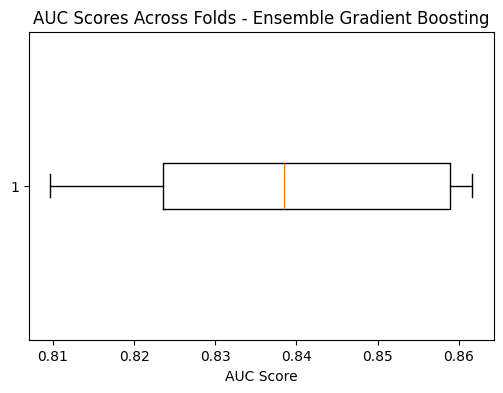


Mean AUC across all folds: 0.8385
Mean Accuracy across all folds: 0.7617
Mean F1-score across folds: 0.6320


In [ ]:
#ensemble

import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, f1_score
import matplotlib.pyplot as plt

# Load the dataset
file_path = "diabetes.csv"
data = pd.read_csv(file_path)

# Replace zeros with NaN for missing values in relevant columns
columns_to_replace_zeros = ['Age', 'BMI', 'Pregnancies', 'SkinThickness', 'Insulin', 'Glucose', 'BloodPressure']
data[columns_to_replace_zeros] = data[columns_to_replace_zeros].replace(0, np.nan)

# Splitting into features and target
X = data.drop('Outcome', axis=1)
y = data['Outcome']

# Initialize base learners with the best hyperparameters
xgb = XGBClassifier(
    colsample_bytree=0.8,
    learning_rate=0.01,
    max_depth=3,
    n_estimators=300,
    subsample=0.8,
    random_state=42,
    eval_metric='logloss'
)

lgb = LGBMClassifier(
    subsample=0.6,
    n_estimators=100,
    max_depth=3,
    learning_rate=0.05,
    colsample_bytree=0.6,
    random_state=42
)

cat = CatBoostClassifier(
    depth=4,
    iterations=300,
    learning_rate=0.05,
    random_state=42,
    verbose=0
)

# Ensemble Voting Classifier
ensemble_model = VotingClassifier(
    estimators=[('xgb', xgb), ('lgb', lgb), ('cat', cat)],
    voting='soft'
)

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_auc = []
fold_f1 = []
fold_accuracy = []

# Prepare for ROC plots
plt.figure(figsize=(10, 8))

# Perform 5-fold cross-validation
for fold, (train_idx, test_idx) in enumerate(kf.split(X, y)):
    print(f"\nProcessing Fold {fold + 1}...")

    # Split the data
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    # Impute missing values
    imputer = SimpleImputer(strategy='mean')
    X_train = imputer.fit_transform(X_train)
    X_test = imputer.transform(X_test)

    # Train Ensemble Model
    ensemble_model.fit(X_train, y_train)

    # Predict probabilities and calculate metrics
    y_pred_proba = ensemble_model.predict_proba(X_test)[:, 1]
    y_pred = (y_pred_proba > 0.5).astype(int)  # Generate binary predictions
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    f1 = f1_score(y_test, y_pred)  # Calculate F1 score
    accuracy = accuracy_score(y_test, y_pred)  # Calculate accuracy

    fold_auc.append(roc_auc)
    fold_f1.append(f1)
    fold_accuracy.append(accuracy)

    # Plot ROC curve for each fold
    plt.plot(fpr, tpr, label=f"Fold {fold + 1} (AUC = {roc_auc:.2f})")

# Finalize the ROC plot
mean_auc = np.mean(fold_auc)
mean_accuracy = np.mean(fold_accuracy)
mean_f1 = np.mean(fold_f1)

plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.title(f"Ensemble Gradient Boosting ROC Curve (Mean AUC = {mean_auc:.2f})")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Boxplot of AUC scores
plt.figure(figsize=(6, 4))
plt.boxplot(fold_auc, vert=False)
plt.title("AUC Scores Across Folds - Ensemble Gradient Boosting")
plt.xlabel("AUC Score")
plt.show()

print(f"\nMean AUC across all folds: {mean_auc:.4f}")
print(f"Mean Accuracy across all folds: {mean_accuracy:.4f}")
print(f"Mean F1-score across folds: {mean_f1:.4f}")
